In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


 deer   car   cat   cat


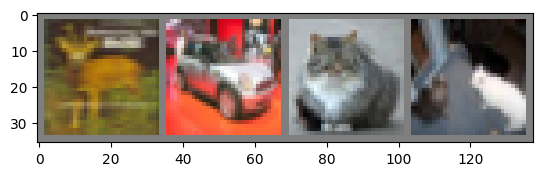

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=200, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=200, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=400, out_channels=400, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(400 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn200 = nn.BatchNorm2d(200)
        self.bn256 = nn.BatchNorm2d(256)
        self.bn400 = nn.BatchNorm2d(400)

    def forward(self, x):
        x1 = F.relu(self.bn64(self.conv1(x)))
        x2 = F.relu(self.bn64(self.conv2(x)))

        x = torch.cat((x1, x2), dim=1)

        x = F.relu(self.bn128(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn256(self.conv4(x)))
        x = F.relu(self.bn256(self.conv5(x)))
        x = self.pool(x)

        x_skip = x

        x = F.relu(self.bn256(self.conv6(x)))
        x = self.bn256(self.conv7(x))

        x = x + x_skip
        x = F.relu(x)

        x3 = F.relu(self.bn200(self.conv8(x)))
        x4 = F.relu(self.bn200(self.conv9(x)))

        x = torch.cat((x3, x4), dim=1)

        x = F.relu(self.bn400(self.conv10(x)))
        x = self.pool(x)


        x = x.view(-1, 400 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


net = Net()
from torchsummary import summary
net = net.to(device)
summary(net, (3, 32, 32))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           1,792
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5          [-1, 128, 32, 32]         147,584
       BatchNorm2d-6          [-1, 128, 32, 32]             256
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]         590,080
      BatchNorm2d-11          [-1, 256, 16, 16]             512
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
      BatchNorm2d-14            

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.791
[1,  4000] loss: 1.465
[1,  6000] loss: 1.241
[1,  8000] loss: 1.097
[1, 10000] loss: 1.035
[1, 12000] loss: 0.972
[2,  2000] loss: 0.837
[2,  4000] loss: 0.810
[2,  6000] loss: 0.804
[2,  8000] loss: 0.801
[2, 10000] loss: 0.744
[2, 12000] loss: 0.716
[3,  2000] loss: 0.631
[3,  4000] loss: 0.619
[3,  6000] loss: 0.630
[3,  8000] loss: 0.603
[3, 10000] loss: 0.596
[3, 12000] loss: 0.601
[4,  2000] loss: 0.485
[4,  4000] loss: 0.495
[4,  6000] loss: 0.490
[4,  8000] loss: 0.501
[4, 10000] loss: 0.496
[4, 12000] loss: 0.496
[5,  2000] loss: 0.386
[5,  4000] loss: 0.402
[5,  6000] loss: 0.406
[5,  8000] loss: 0.411
[5, 10000] loss: 0.422
[5, 12000] loss: 0.414
[6,  2000] loss: 0.312
[6,  4000] loss: 0.325
[6,  6000] loss: 0.352
[6,  8000] loss: 0.335
[6, 10000] loss: 0.354
[6, 12000] loss: 0.342
[7,  2000] loss: 0.253
[7,  4000] loss: 0.271
[7,  6000] loss: 0.268
[7,  8000] loss: 0.289
[7, 10000] loss: 0.291
[7, 12000] loss: 0.289
[8,  2000] loss: 0.190
[8,  4000] 

GroundTruth:    cat  ship  ship plane


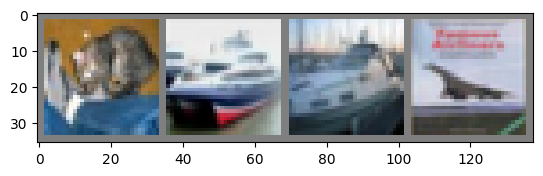

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images, labels = data[0].to(device), data[1].to(device)
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane plane  bird  frog


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 92 %
Accuracy of  bird : 79 %
Accuracy of   cat : 69 %
Accuracy of  deer : 92 %
Accuracy of   dog : 81 %
Accuracy of  frog : 92 %
Accuracy of horse : 84 %
Accuracy of  ship : 92 %
Accuracy of truck : 91 %
